In [ ]:
import pandas as pd
import json
import numpy as np
import os

scenario = 'random_moves_3_robots'

radar_files = [
    "measurements/radar_data/node_1_measurement_robomaster_random_moves_3_robots.txt",
    "measurements/radar_data/node_2_measurement_robomaster_random_moves_3_robots.txt",
    "measurements/radar_data/node_3_measurement_robomaster_random_moves_3_robots.txt"
]

vicon_files = [
    "measurements/vicon_data/random_moves_3_robots_10_20250115_171905.txt"
] #"vicon_data_sample_multi.txt"


output_filtered_radar_filename = "output/filtered_radar_"
output_vicon_data_filename = "output/vicon_resample_" + scenario + ".csv"
output_sync_radar_nodes_filename = "output/sync_radar_nodes_" + scenario + ".csv"
output_final_filename = "output/" + scenario + ".csv"

'''
Radar data interpolations:
- Vertical 1 Robot
- Horizontal 2 Robots --> node 3
'''

### Radar Data Reading ###

In [ ]:
# Read radar data and create separate DataFrames for each node
def read_radar_data(file_paths):
    radar_dfs = {}  # Dictionary to store DataFrames for each node

    for file in file_paths:
        # Extract Node ID from file name and ensure proper formatting
        try:
            filename = file.split("/")[-1]  # Extract just the file name
            node_number = filename.split("_")[1]  # Extract the number part (e.g., '1', '2', '3')
            node_id = f"node_{node_number}"  # Properly format Node ID as 'node_1', 'node_2', etc.
        except IndexError:
            raise ValueError(f"Invalid file name format: {file}. Expected 'node_x_measurement_robomaster_scenario.txt'.")

        radar_data = []
        try:
            with open(file, 'r') as f:
                for line in f:
                    try:
                        radar_data.append(json.loads(line))  # Parse JSON line by line
                    except json.JSONDecodeError:
                        print(f"Skipping invalid JSON line in file {file}: {line.strip()}")
        except FileNotFoundError:
            raise FileNotFoundError(f"File not found: {file}")

        if not radar_data:
            print(f"No valid data found in file: {file}")
            continue  # Skip this file if no data

        # Create a DataFrame for this node
        df = pd.DataFrame(radar_data)
        df.rename(columns={'timestamp': f'{node_id}_timestamp'}, inplace=True)  # Rename timestamp column
        df['Node_ID'] = node_id  # Add properly formatted Node ID column

        radar_dfs[node_id] = df  # Store the DataFrame in the dictionary

    if not radar_dfs:
        raise ValueError("No valid radar data files were processed.")
    
    return radar_dfs

# def read_radar_data_(file_paths):
#     radar_dataframes = []
#     for file in file_paths:
#         with open(f"measurements/radar_data/{file}", 'r') as f:
#             radar_data = [json.loads(line) for line in f]
#             df = pd.DataFrame(radar_data)
#             df.rename(columns={'timestamp': 'timestamp_radar'}, inplace=True)
#             radar_dataframes.append(df)
#     radar_df = pd.concat(radar_dataframes, ignore_index=True)
#     return radar_df

# Step 1: Read radar data and create separate DataFrames for each node

radar_dfs = read_radar_data(radar_files)

# Print separate DataFrames for each node
for node_id in ['node_1', 'node_2', 'node_3']:
    if node_id in radar_dfs:
        print(f"{node_id.capitalize()} DataFrame:")
        print(radar_dfs[node_id].head())
    else:
        print(f"{node_id.capitalize()} data not found.")

radar_dfs

In [ ]:
radar_dfs['node_2']

### Vicon Data Reading ###

In [ ]:
# Step 2: Read and decode Vicon data files


def read_vicon_data(file_paths):
    vicon_dataframes = []
    
    for file in file_paths:
        with open(file, 'r') as f:
            rows = []
            for line in f:
                line = line.strip()  # Remove whitespace or newline characters
                if line:  # Skip empty lines
                    try:
                        vicon_dict = eval(line)  # Evaluate the line into a dictionary
                        object_count = 1  # Initialize object counter
                        row_data = {}
                        for key, value in vicon_dict.items():
                            # Robust check to skip rows where all values are zero
                            if isinstance(value, dict) and all(v == 0 for v in value.values()):
                                continue  # Skip this entry
                            # Extract object name from key
                            object_name = key.split("/")[1]
                            # Rename keys with object_name prefix and handle multiple objects
                            renamed_value = {
                                f"{object_name}_{k}": v
                                for k, v in value.items()
                                if k not in ['frame_number', 'total_latency', 'quality']
                            }
                            # Add vicon_timestamp for the first object
                            if object_count == 1:
                                renamed_value['vicon_timestamp'] = renamed_value.pop(f"{object_name}_system_time") / 1e9
                            else:
                                renamed_value[f'object_name_{object_count}'] = object_name
                                renamed_value[f"object_name_{object_count}_timestamp"] = renamed_value.pop(
                                    f"{object_name}_system_time"
                                ) / 1e9
                            # Add object_name for the first object
                            if object_count == 1:
                                renamed_value['object_name_1'] = object_name
                            row_data.update(renamed_value)
                            object_count += 1
                        # Add row if it's not empty
                        if row_data:  # Ensure that the row contains valid data
                            rows.append(row_data)
                    except SyntaxError as e:
                        print(f"Error parsing line: {line}\n{e}")
            
            # Create a DataFrame for the parsed rows
            if rows:
                df = pd.DataFrame(rows)
                vicon_dataframes.append(df)
    
    # Combine all DataFrames into one
    vicon_df = pd.concat(vicon_dataframes, ignore_index=True) if vicon_dataframes else pd.DataFrame()

    # Reorder columns: vicon_timestamp first, followed by object_name columns, then the rest
    if not vicon_df.empty:
        columns = sorted(
            [col for col in vicon_df.columns if 'vicon_timestamp' in col] +
            [col for col in vicon_df.columns if col.startswith('object_name')],
            key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else 0
        )
        remaining_columns = [col for col in vicon_df.columns if col not in columns]
        vicon_df = vicon_df[columns + remaining_columns]
    
    return vicon_df


vicon_df = read_vicon_data(vicon_files)
vicon_df



In [5]:
# Save vicon data
#vicon_df.to_csv('output/vicon_data_test.csv', index=False)

In [6]:
# Function to read and process Vicon data
# Function to manually decode and process Vicon data old version
# def read_vicon_data(file_paths):
#     vicon_dataframes = []
#     for file in file_paths:
#         with open(f"measurements/vicon_data/{file}", 'r') as f:
#             rows = []
#             for line in f:
#                 line = line.strip()  # Remove whitespace or newline characters
#                 if line:  # Skip empty lines
#                     # Manually parse the line
#                     try:
#                         vicon_dict = eval(line)  # Evaluate the line into a dictionary
#                         for key, value in vicon_dict.items():
#                             # Check if all values in the entry are zero
#                             if all(val == 0 for val in value.values()):
#                                 continue  # Skip this entry
#                             # Extract object name from key
#                             object_name = key.split("/")[1]
#                             # Add object name and system time (converted to seconds) to the data
#                             value['object_name'] = object_name
#                             value['system_time'] = value['system_time'] / 1e9  # Convert to seconds
#                             rows.append(value)
#                     except SyntaxError as e:
#                         print(f"Error parsing line: {line}\n{e}")
#             # Create a DataFrame for the parsed rows
#             if rows:
#                 df = pd.DataFrame(rows)
#                 vicon_dataframes.append(df)
#     # Combine all dataframes into one
#     vicon_df = pd.concat(vicon_dataframes, ignore_index=True) if vicon_dataframes else pd.DataFrame()
#     return vicon_df

# def read_vicon_data(file_paths):
#     vicon_dataframes = []
    
#     for file in file_paths:
#         with open(file, 'r') as f:
#             rows = []
#             for line in f:
#                 line = line.strip()  # Remove whitespace or newline characters
#                 if line:  # Skip empty lines
#                     try:
#                         vicon_dict = eval(line)  # Evaluate the line into a dictionary
#                         for key, value in vicon_dict.items():
#                             # Check if all values in the entry are zero
#                             if all(val == 0 for val in value.values()):
#                                 continue  # Skip this entry
#                             # Extract object name from key
#                             object_name = key.split("/")[1]
#                             # Rename keys with object_name prefix
#                             renamed_value = {f"{object_name}_{k}": v for k, v in value.items() if k not in ['frame_number', 'total_latency', 'quality']}
#                             renamed_value['object_name'] = object_name
#                             renamed_value['vicon_timestamp'] = renamed_value.pop(f"{object_name}_system_time") / 1e9  # Rename system_time for the first object
#                             rows.append(renamed_value)
#                     except SyntaxError as e:
#                         print(f"Error parsing line: {line}\n{e}")
            
#             # Create a DataFrame for the parsed rows
#             if rows:
#                 df = pd.DataFrame(rows)
#                 vicon_dataframes.append(df)
    
#     # Combine all DataFrames into one
#     vicon_df = pd.concat(vicon_dataframes, ignore_index=True) if vicon_dataframes else pd.DataFrame()
#     return vicon_df

### Resampling Vicon Data ###

In [ ]:
def resample_vicon_old(df_vicon, resample_interval='40ms'):
    if df_vicon.empty:
        return df_vicon  # Return empty DataFrame if input is empty
    
    # Convert `vicon_timestamp` to datetime for resampling
    df_vicon['time_resample'] = pd.to_datetime(df_vicon['vicon_timestamp'], unit='s')
    
    # Handle non-unique indices by aggregating duplicate timestamps
    df_vicon = df_vicon.groupby('time_resample').mean().reset_index()
    
    # Set datetime as index for resampling
    df_vicon = df_vicon.set_index('time_resample').sort_index()
    
    # Resample and forward-fill missing values
    df_vicon_resampled = df_vicon.resample(resample_interval).ffill()
    
    # Drop rows with NaN values after resampling
    df_vicon_resampled = df_vicon_resampled.dropna().reset_index()
    df_vicon_resampled = df_vicon_resampled.drop('time_resample', axis=1)
    
    # Rename resampled timestamp to `vicon_timestamp`
    #df_vicon_resampled.rename(columns={'time_resample': 'vicon_timestamp'}, inplace=True)
    
    # Ensure `vicon_timestamp` is in seconds format
    #df_vicon_resampled['vicon_timestamp'] = df_vicon_resampled['vicon_timestamp'].astype(int) / 1e9
    
    return df_vicon_resampled

def resample_vicon(df_vicon, resample_interval='40ms'):
    if df_vicon.empty:
        return df_vicon  # Return empty DataFrame if input is empty
    
    # Convert `vicon_timestamp` to datetime for resampling
    df_vicon['time_resample'] = pd.to_datetime(df_vicon['vicon_timestamp'], unit='s')
    
    # Separate non-numerical columns
    non_numerical_cols = [col for col in df_vicon.columns if df_vicon[col].dtype == 'object']
    numerical_cols = [col for col in df_vicon.columns if col not in non_numerical_cols + ['time_resample']]

    # Aggregate non-numerical columns by taking the first value
    df_vicon_non_num = df_vicon.groupby('time_resample')[non_numerical_cols].first()
    
    # Aggregate numerical columns using forward-fill
    df_vicon_num = df_vicon.groupby('time_resample')[numerical_cols].mean()
    
    # Combine numerical and non-numerical data
    df_vicon_combined = pd.concat([df_vicon_num, df_vicon_non_num], axis=1).reset_index()
    
    # Resample based on time interval and forward-fill missing values
    df_vicon_combined = df_vicon_combined.set_index('time_resample').sort_index()
    df_vicon_resampled = df_vicon_combined.resample(resample_interval).ffill().dropna().reset_index()
    df_vicon_resampled = df_vicon_resampled.drop('time_resample', axis=1)

    # Rename resampled timestamp back to `vicon_timestamp`
    #df_vicon_resampled.rename(columns={'time_resample': 'vicon_timestamp'}, inplace=True)
    
    # Ensure `vicon_timestamp` is in seconds format
    #df_vicon_resampled['vicon_timestamp'] = df_vicon_resampled['vicon_timestamp'].astype(float)
    
    return df_vicon_resampled


resampled_vicon_df = resample_vicon(vicon_df, resample_interval='25ms')
resampled_vicon_df

In [8]:
# Save resample vicon data
resampled_vicon_df.to_csv(output_vicon_data_filename, index=False)

### Filter the Radar Data ###

In [ ]:
# Step 3: Filter radar data based on Vicon timestamps
# Filter radar data based on Vicon timestamps
def filter_radar_by_vicon_time(radar_df, vicon_df):
    start_time = resampled_vicon_df['vicon_timestamp'].min()
    end_time = resampled_vicon_df['vicon_timestamp'].max()
    filtered_radar_df = radar_df[
        (radar_df[f'{radar_df["Node_ID"].iloc[0]}_timestamp'] >= start_time) &
        (radar_df[f'{radar_df["Node_ID"].iloc[0]}_timestamp'] <= end_time)
    ]
    print("num of rows: ", len(filtered_radar_df))
    return filtered_radar_df

filtered_radar_dfs = {}  # Create a new dictionary to store filtered data

for node_id in radar_dfs:
    print(node_id)
    filtered_radar_dfs[node_id] = filter_radar_by_vicon_time(radar_dfs[node_id], resampled_vicon_df)
    filtered_radar_dfs[node_id] = filtered_radar_dfs[node_id].reset_index(drop=True)

In [ ]:
# Print and store to csv separate DataFrames for each node
for node_id in ['node_1', 'node_2', 'node_3']:
    if node_id in filtered_radar_dfs:
        print(f"{node_id.capitalize()} DataFrame:")
        print(filtered_radar_dfs[node_id].head())
        print("Saving Filtered Radar Data ", node_id)
        filtered_radar_dfs[node_id].to_csv(output_filtered_radar_filename + node_id + '_' + scenario + '.csv', index=False, na_rep='NaN')
    else:
        print(f"{node_id.capitalize()} data not found.")

filtered_radar_dfs['node_2']

In [ ]:
print(filtered_radar_dfs['node_1']['node_1_timestamp'].dtype)  # Should be float64
print(filtered_radar_dfs['node_2']['node_2_timestamp'].dtype)  # Should be float64
print(filtered_radar_dfs['node_3']['node_3_timestamp'].dtype)  # Should be float64

### Synchronize Radar Data per Node ###

In [12]:
# # Step 4: Synchronize radar data across nodes WITHOUT INTERPOLATION

# def synchronize_radar_nodes(radar_dfs):
#     node_2_df = radar_dfs['node_2']
#     synchronized_data = []

#     for _, node_2_row in node_2_df.iterrows():
#         sync_row = {}  # Initialize a new dictionary to store synchronized data

#         # Add Node 1 data
#         if 'node_1' in radar_dfs:
#             node_1_df = radar_dfs['node_1']
#             closest_idx = (np.abs(node_1_df['node_1_timestamp'] - node_2_row['node_2_timestamp'])).idxmin()
#             node_1_data = node_1_df.loc[closest_idx].drop('Node_ID').to_dict()  # Drop Node_ID column
#             for key, value in node_1_data.items():
#                 # Add timestamp column without prefix
#                 if key == 'node_1_timestamp':
#                     sync_row[key] = value
#                 else:
#                     sync_row[f'node_1_{key}'] = value

#         # Add Node 2 data
#         node_2_data = node_2_row.drop('Node_ID').to_dict()  # Drop Node_ID column
#         for key, value in node_2_data.items():
#             # Add timestamp column without prefix
#             if key == 'node_2_timestamp':
#                 sync_row[key] = value
#             else:
#                 sync_row[f'node_2_{key}'] = value

#         # Add Node 3 data
#         if 'node_3' in radar_dfs:
#             node_3_df = radar_dfs['node_3']
#             closest_idx = (np.abs(node_3_df['node_3_timestamp'] - node_2_row['node_2_timestamp'])).idxmin()
#             node_3_data = node_3_df.loc[closest_idx].drop('Node_ID').to_dict()  # Drop Node_ID column
#             for key, value in node_3_data.items():
#                 # Add timestamp column without prefix
#                 if key == 'node_3_timestamp':
#                     sync_row[key] = value
#                 else:
#                     sync_row[f'node_3_{key}'] = value

#         synchronized_data.append(sync_row)

#         # Convert synchronized data into a DataFrame
#         synchronized_df = pd.DataFrame(synchronized_data)

#         # Reorder columns to ensure Node 1 data comes first, followed by Node 2 and Node 3
#         column_order = (
#             [col for col in synchronized_df.columns if col.startswith('node_1_') or col == 'node_1_timestamp'] +
#             [col for col in synchronized_df.columns if col.startswith('node_2_') or col == 'node_2_timestamp'] +
#             [col for col in synchronized_df.columns if col.startswith('node_3_') or col == 'node_3_timestamp']
#         )
#         synchronized_df = synchronized_df[column_order]
#     return synchronized_df


# synchronized_radar_df = synchronize_radar_nodes(filtered_radar_dfs)
# synchronized_radar_df

In [ ]:
# Step 4: Synchronize radar data across nodes WITH INTERPOLATION
import numpy as np
import pandas as pd

def detect_and_fill_gaps_v2(df, timestamp_col, sampling_interval, fields_to_interpolate, interpolation_enabled=True):
    """
    Detect and fill gaps in radar data by inserting missing timestamps and handling gaps.
    Args:
        df (pd.DataFrame): Input DataFrame containing radar data.
        timestamp_col (str): Column name for the timestamp (in UNIX seconds).
        sampling_interval (float): Expected interval in seconds (e.g., 0.05 for 50ms).
        fields_to_interpolate (list): List of radar data fields to handle during gaps.
        interpolation_enabled (bool): Whether to perform interpolation for missing data.

    Returns:
        pd.DataFrame: DataFrame with gaps filled and data interpolated (if enabled).
    """
    # Ensure DataFrame is sorted by timestamp
    df = df.sort_values(timestamp_col).reset_index(drop=True)

    # Detect gaps where the timestamp difference exceeds 5 seconds
    df['time_diff'] = df[timestamp_col].diff()

    # Generate a complete timestamp range by filling gaps
    complete_timestamps = []
    for i in range(len(df) - 1):
        t_now, t_next = df.loc[i, timestamp_col], df.loc[i + 1, timestamp_col]
        complete_timestamps.append(t_now)

        # Fill gaps by interpolating timestamps based on sampling_interval
        gap_length = t_next - t_now
        if gap_length > 5:  # If gap > 5 seconds
            num_interpolated_points = int(gap_length / sampling_interval)
            print(f"t_now: {t_now}, t_next: {t_next}, num points: {num_interpolated_points}")
            missing_timestamps = np.linspace(t_now + sampling_interval, t_next - sampling_interval, num_interpolated_points)
            complete_timestamps.extend(missing_timestamps)
    complete_timestamps.append(df[timestamp_col].iloc[-1])

    # for i in range(len(df) - 1):
    #     t_now, t_next = df.loc[i, timestamp_col], df.loc[i + 1, timestamp_col]
    #     complete_timestamps.append(t_now)

    #     # Fill gaps by interpolating timestamps based on sampling_interval
    #     if t_next - t_now > 5:  # If gap > 5 seconds
    #         missing_timestamps = np.arange(t_now + sampling_interval, t_next, sampling_interval)
    #         complete_timestamps.extend(missing_timestamps)
    # complete_timestamps.append(df[timestamp_col].iloc[-1])

    # Create a DataFrame with all timestamps
    complete_df = pd.DataFrame({timestamp_col: complete_timestamps})
    
    # Merge the original data into the complete timestamp range
    df = pd.merge(complete_df, df, on=timestamp_col, how='left')

    # Fill gaps with NaN for radar fields
    if interpolation_enabled:
        for field in fields_to_interpolate:
            if field in df.columns:
                df[field] = df[field].interpolate(method='linear', limit_direction='both')

    # Remove temporary columns and return
    df.drop(columns=['time_diff'], errors='ignore', inplace=True)
    return df


def synchronize_radar_nodes_v2(radar_dfs, sampling_interval=0.05, interpolation_enabled=False):
    """
    Synchronize radar data across nodes, filling gaps and interpolating where necessary.
    Args:
        radar_dfs (dict): Dictionary of DataFrames for each radar node.
        sampling_interval (float): Sampling interval in seconds (e.g., 0.05 for 50ms).
        interpolation_enabled (bool): Whether to enable interpolation for gaps.

    Returns:
        pd.DataFrame: Synchronized radar data across nodes.
    """
    node_2_df = radar_dfs['node_2']
    synchronized_data = []

    # Detect and handle gaps in Node 1 and Node 3
    for node_id in ['node_1', 'node_3']:
        if node_id in radar_dfs:
            radar_dfs[node_id] = detect_and_fill_gaps_v2(
                radar_dfs[node_id],
                timestamp_col=f'{node_id}_timestamp',
                sampling_interval=sampling_interval,
                fields_to_interpolate=[
                    'numObj', 'x', 'y', 'z', 'azimuth', 'range', 'rangeProfile', 'snr'
                ],
                interpolation_enabled=interpolation_enabled
            )

    for _, node_2_row in node_2_df.iterrows():
        sync_row = {}

        # Add Node 1 data
        if 'node_1' in radar_dfs:
            node_1_df = radar_dfs['node_1']
            closest_idx = (np.abs(node_1_df['node_1_timestamp'] - node_2_row['node_2_timestamp'])).idxmin()
            node_1_data = node_1_df.loc[closest_idx].drop('Node_ID', errors='ignore').to_dict()
            for key, value in node_1_data.items():
                if key == 'node_1_timestamp':
                    sync_row[key] = value
                else:
                    sync_row[f'node_1_{key}'] = value

        # Add Node 2 data
        node_2_data = node_2_row.drop('Node_ID', errors='ignore').to_dict()
        for key, value in node_2_data.items():
            if key == 'node_2_timestamp':
                sync_row[key] = value
            else:
                sync_row[f'node_2_{key}'] = value

        # Add Node 3 data
        if 'node_3' in radar_dfs:
            node_3_df = radar_dfs['node_3']
            closest_idx = (np.abs(node_3_df['node_3_timestamp'] - node_2_row['node_2_timestamp'])).idxmin()
            node_3_data = node_3_df.loc[closest_idx].drop('Node_ID', errors='ignore').to_dict()
            for key, value in node_3_data.items():
                if key == 'node_3_timestamp':
                    sync_row[key] = value
                else:
                    sync_row[f'node_3_{key}'] = value

        synchronized_data.append(sync_row)

    # Convert synchronized data into a DataFrame
    synchronized_df = pd.DataFrame(synchronized_data)

    # Reorder columns
    column_order = (
        [col for col in synchronized_df.columns if col.startswith('node_1_') or col == 'node_1_timestamp'] +
        [col for col in synchronized_df.columns if col.startswith('node_2_') or col == 'node_2_timestamp'] +
        [col for col in synchronized_df.columns if col.startswith('node_3_') or col == 'node_3_timestamp']
    )
    synchronized_df = synchronized_df[column_order]

    return synchronized_df

synchronized_radar_df = synchronize_radar_nodes_v2(filtered_radar_dfs, sampling_interval=0.05, interpolation_enabled=False)
synchronized_radar_df

In [14]:
# Save synchronized radar data
synchronized_radar_df.to_csv(output_sync_radar_nodes_filename, index=False, na_rep='NaN')

In [15]:
# # Step 5: Synchronize radar and Vicon data
# # Find the closest Vicon timestamp for each radar timestamp
# # Function to filter radar data based on Vicon timestamps
# def filter_radar_by_vicon_time(radar_df, vicon_df):
#     start_time = vicon_df['system_time'].min()
#     end_time = vicon_df['system_time'].max()
#     filtered_radar_df = radar_df[(radar_df['timestamp_radar'] >= start_time) & 
#                                  (radar_df['timestamp_radar'] <= end_time)]
#     return filtered_radar_df



# filtered_radar_df = filter_radar_by_vicon_time(radar_df, vicon_df)
# filtered_radar_df

### Synchronization of Radar and Vicon Data ###

In [ ]:
import pandas as pd

 # Step 5: Synchronize radar and Vicon data

# Function to synchronize radar and Vicon data
# def synchronize_data(radar_df, vicon_df):
#     synchronized_data = []
#     for _, radar_row in radar_df.iterrows():
#         closest_vicon_idx = (np.abs(vicon_df['system_time'] - radar_row['timestamp_radar'])).idxmin()
#         closest_vicon_row = vicon_df.loc[closest_vicon_idx]
#         combined_row = {**radar_row.to_dict(), **closest_vicon_row.to_dict()}
#         synchronized_data.append(combined_row)
#     synchronized_df = pd.DataFrame(synchronized_data)
#     return synchronized_df


def synchronize_radar_vicon(synchronized_radar_df, vicon_df):
    synchronized_data = []

    for _, radar_row in synchronized_radar_df.iterrows():
        # Find closest Vicon timestamp to Node 2 timestamp
        closest_vicon_idx = (np.abs(vicon_df['vicon_timestamp'] - radar_row['node_2_timestamp'])).idxmin()
        closest_vicon_row = vicon_df.loc[closest_vicon_idx]
        combined_row = {**closest_vicon_row.to_dict(), **radar_row.to_dict()}
        synchronized_data.append(combined_row)

    # Create a DataFrame from the synchronized data
    synchronized_df = pd.DataFrame(synchronized_data)

    # Ensure `vicon_timestamp` and `object_name_x` are placed at the beginning
    vicon_columns = sorted(
        [col for col in synchronized_df.columns if 'vicon_timestamp' in col or col.startswith('object_name')],
        key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else 0
    )
    remaining_columns = [col for col in synchronized_df.columns if col not in vicon_columns]
    synchronized_df = synchronized_df[vicon_columns + remaining_columns]

    return synchronized_df


final_synchronized_df  = synchronize_radar_vicon(synchronized_radar_df, resampled_vicon_df)
final_synchronized_df



# # Display the final DataFrame
# synchronized_df.head()

In [17]:
# # Save the synchronized data to a CSV file
final_synchronized_df.to_csv(output_final_filename, index=False, na_rep='NaN')

### Read Radar Node Position ###

In [ ]:
import pandas as pd
import json
import numpy as np
import os
# Step 2: Read and decode Vicon data files

def read_vicon_radar_pos(file_paths):
    vicon_dataframes = []
    
    for file in file_paths:
        with open(file, 'r') as f:
            rows = []
            for line in f:
                line = line.strip()  # Remove whitespace or newline characters
                if line:  # Skip empty lines
                    try:
                        vicon_dict = eval(line)  # Evaluate the line into a dictionary
                        object_count = 1  # Initialize object counter
                        row_data = {}
                        for key, value in vicon_dict.items():
                            # Robust check to skip rows where all values are zero
                            if isinstance(value, dict) and all(v == 0 for v in value.values()):
                                continue  # Skip this entry
                            # Extract object name from key
                            object_name = key.split("/")[1]
                            # Rename keys with object_name prefix and handle multiple objects
                            renamed_value = {
                                f"{object_name}_{k}": v
                                for k, v in value.items()
                                if k not in ['frame_number', 'total_latency', 'quality']
                            }
                            # Add vicon_timestamp for the first object
                            if object_count == 1:
                                renamed_value['vicon_timestamp'] = renamed_value.pop(f"{object_name}_system_time") / 1e9
                            else:
                                renamed_value[f'object_name_{object_count}'] = object_name
                                renamed_value[f"object_name_{object_count}_timestamp"] = renamed_value.pop(
                                    f"{object_name}_system_time"
                                ) / 1e9
                            # Add object_name for the first object
                            if object_count == 1:
                                renamed_value['object_name_1'] = object_name
                            row_data.update(renamed_value)
                            object_count += 1
                        # Add row if it's not empty
                        if row_data:  # Ensure that the row contains valid data
                            rows.append(row_data)
                    except SyntaxError as e:
                        print(f"Error parsing line: {line}\n{e}")
            
            # Create a DataFrame for the parsed rows
            if rows:
                df = pd.DataFrame(rows)
                vicon_dataframes.append(df)
    
    # Combine all DataFrames into one
    vicon_df = pd.concat(vicon_dataframes, ignore_index=True) if vicon_dataframes else pd.DataFrame()

    # Reorder columns: vicon_timestamp first, followed by object_name columns, then the rest
    if not vicon_df.empty:
        columns = sorted(
            [col for col in vicon_df.columns if 'vicon_timestamp' in col] +
            [col for col in vicon_df.columns if col.startswith('object_name')],
            key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isdigit() else 0
        )
        remaining_columns = [col for col in vicon_df.columns if col not in columns]
        vicon_df = vicon_df[columns + remaining_columns]
    
    return vicon_df

radar_pos_vicon_files = [
    "measurements/vicon_data/radar_TI_positions_new_20250114_113456.txt"
]

radar_pos_vicon_df = read_vicon_radar_pos(radar_pos_vicon_files)
radar_pos_vicon_df



,vicon_timestamp,object_name_2_timestamp,object_name_3_timestamp,object_name_1,object_name_2,object_name_3,radar_TI_1_pos_x,radar_TI_1_pos_y,radar_TI_1_pos_z,radar_TI_1_yaw,...,radar_TI_2_rot_x,radar_TI_2_rot_y,radar_TI_2_rot_z,radar_TI_3_pos_x,radar_TI_3_pos_y,radar_TI_3_pos_z,radar_TI_3_yaw,radar_TI_3_rot_x,radar_TI_3_rot_y,radar_TI_3_rot_z
0,1.736851e+09,1.736851e+09,1.736851e+09,radar_TI_1,radar_TI_2,radar_TI_3,-8.734543,-3.853580,1.408221,0.380653,...,0.053185,-0.026248,0.989981,9.846064,-3.148406,1.438998,2.547940,0.051977,-0.018270,0.955241
1,1.736851e+09,1.736851e+09,1.736851e+09,radar_TI_1,radar_TI_2,radar_TI_3,-8.734543,-3.853580,1.408221,0.380653,...,0.053185,-0.026248,0.989981,9.846064,-3.148406,1.438998,2.547940,0.051977,-0.018270,0.955241
2,1.736851e+09,1.736851e+09,1.736851e+09,radar_TI_1,radar_TI_2,radar_TI_3,-8.734558,-3.853610,1.408112,0.380847,...,0.052953,-0.026067,0.990013,9.846022,-3.148400,1.438932,2.549167,0.051855,-0.017698,0.955428
3,1.736851e+09,1.736851e+09,1.736851e+09,radar_TI_1,radar_TI_2,radar_TI_3,-8.734558,-3.853610,1.408112,0.380847,...,0.052953,-0.026067,0.990013,9.846022,-3.148400,1.438932,2.549167,0.051855,-0.017698,0.955428
4,1.736851e+09,1.736851e+09,1.736851e+09,radar_TI_1,radar_TI_2,radar_TI_3,-8.734615,-3.853594,1.408101,0.380422,...,0.052953,-0.026067,0.990013,9.846022,-3.148400,1.438932,2.549167,0.051855,-0.017698,0.955428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,1.736851e+09,1.736851e+09,1.736851e+09,radar_TI_1,radar_TI_2,radar_TI_3,-8.734590,-3.853580,1.408223,0.380654,...,0.052940,-0.026108,0.989988,9.846121,-3.148472,1.439090,2.547529,0.052575,-0.018542,0.955157
1066,1.736851e+09,1.736851e+09,1.736851e+09,radar_TI_1,radar_TI_2,radar_TI_3,-8.734464,-3.853503,1.408486,0.380772,...,0.052627,-0.025988,0.990010,9.846138,-3.148513,1.439102,2.547563,0.052408,-0.018499,0.955168
1067,1.736851e+09,1.736851e+09,1.736851e+09,radar_TI_1,radar_TI_2,radar_TI_3,-8.734477,-3.853542,1.408466,0.380719,...,0.052441,-0.025922,0.990013,9.846114,-3.148499,1.439067,2.547736,0.052201,-0.018371,0.955202
1068,1.736851e+09,1.736851e+09,1.736851e+09,radar_TI_1,radar_TI_2,radar_TI_3,-8.734477,-3.853542,1.408466,0.380719,...,0.052441,-0.025922,0.990013,9.846114,-3.148499,1.439067,2.547736,0.052201,-0.018371,0.955202


In [7]:
import pandas as pd
import re

def compute_radar_averages(vicon_df):
    """
    Computes the average position and orientation for each radar (Radar 1, Radar 2, Radar 3).
    
    Args:
        vicon_df (pd.DataFrame): DataFrame containing Vicon radar position data.

    Returns:
        pd.DataFrame: A DataFrame with averaged position and orientation data per radar.
    """
    # Identify radar names (e.g., radar_TI_1, radar_TI_2, radar_TI_3)
    radar_objects = sorted(set(col.split("_")[2] for col in vicon_df.columns if col.startswith("radar_TI_")))

    # Define relevant columns for averaging
    relevant_columns = ['pos_x', 'pos_y', 'pos_z', 'yaw', 'rot_x', 'rot_y', 'rot_z']

    # Initialize a dictionary to store the averages
    radar_averages = {}

    for radar_id in radar_objects:
        radar_data = {}
        for col in relevant_columns:
            radar_col_name = f"radar_TI_{radar_id}_{col}"
            if radar_col_name in vicon_df.columns:
                radar_data[col] = vicon_df[radar_col_name].mean()  # Compute column mean

        radar_averages[f"Radar {radar_id}"] = radar_data  # Store averages under "Radar X"

    # Convert the dictionary to a DataFrame and transpose it for readability
    radar_averages_df = pd.DataFrame(radar_averages).T
    radar_averages_df.index.name = "Radar"

    return radar_averages_df

# Read the Vicon data
#vicon_df = read_vicon_data(vicon_files)

# Compute the average positions for radar objects
average_radar_positions_df = compute_radar_averages(radar_pos_vicon_df)

# Save the results to a CSV file
#average_radar_positions_df.to_csv("average_radar_positions.csv", index=False)

# Display results
print("Averaged Radar Positions DataFrame:")
print(average_radar_positions_df.head())


Averaged Radar Positions DataFrame:
            pos_x     pos_y     pos_z       yaw     rot_x     rot_y     rot_z
Radar                                                                        
Radar 1 -8.734629 -3.853581  1.408195  0.380674  0.017957 -0.082447  0.185975
Radar 2  9.848419  4.269616  1.446270 -2.886167  0.052617 -0.025978  0.990011
Radar 3  9.846088 -3.148457  1.439037  2.548011  0.052292 -0.018287  0.955239


In [13]:
#average_radar_positions_df.to_csv("average_radar_positions.csv", index=False)

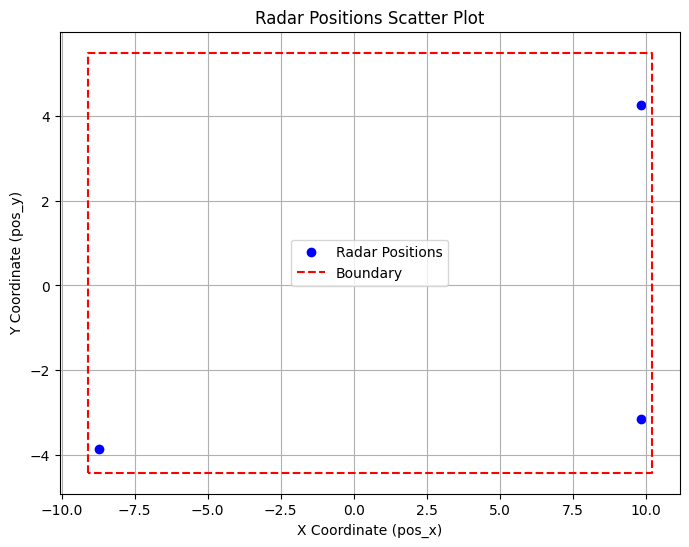

In [12]:
import matplotlib.pyplot as plt

def plot_radar_positions(df, x_col="pos_x", y_col="pos_y"):
    """
    Plots a scatter plot of radar positions based on pos_x and pos_y.

    Args:
        df (pd.DataFrame): DataFrame containing radar positions.
        x_col (str): Column name for X coordinates (default: 'pos_x').
        y_col (str): Column name for Y coordinates (default: 'pos_y').
    """
    # Define boundary coordinates
    boundary_x = [-9.1, -9.1, 10.2, 10.2, -9.1]
    boundary_y = [-4.42, 5.5, 5.5, -4.42, -4.42]

    plt.figure(figsize=(8, 6))
    
    # Scatter plot of radar positions
    plt.scatter(df[x_col], df[y_col], color="blue", marker="o", label="Radar Positions")

    # Plot boundary box
    plt.plot(boundary_x, boundary_y, "r--", label="Boundary")

    # Labels and title
    plt.xlabel("X Coordinate (pos_x)")
    plt.ylabel("Y Coordinate (pos_y)")
    plt.title("Radar Positions Scatter Plot")
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()

# Call the function to plot
plot_radar_positions(average_radar_positions_df)


### Map Tranformation of local 3D Point Clouds to Global Frame ###

In [ ]:
import pandas as pd
import numpy as np

# Load radar positions (Vicon-based global coordinates)
radar_positions_df = pd.read_csv("average_radar_positions.csv")

# Function to extract robot IDs from "object_name_" columns
def extract_robot_ids(df):
    """
    Extracts unique robot IDs from columns following the 'object_name_' pattern.
    """
    robot_cols = [col for col in df.columns if col.startswith("object_name_")]
    return {df[col].dropna().unique()[0]: col for col in robot_cols}  # Extract {ID: column_name} pairs

# Function to compute rotation matrix from yaw
def rotation_matrix(yaw):
    """
    Compute a 3x3 rotation matrix for given yaw (in degrees).
    """
    theta = np.radians(yaw)
    R = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return R

# Function to transform local 3D point clouds to global coordinates
def transform_to_global(df, radar_positions):
    """
    Transforms radar's local 3D point clouds (x, y, z) into global coordinates.
    Adds new columns with transformed points.
    """
    # Extract robots
    robot_id_map = extract_robot_ids(df)  # {robot_name: column}

    # Loop through each radar node
    for radar_id in ["node_1", "node_2", "node_3"]:
        radar_data_cols = [f"{radar_id}_x", f"{radar_id}_y", f"{radar_id}_z"]
        
        if all(col in df.columns for col in radar_data_cols):
            # Get radar position and yaw
            radar_row = radar_positions[radar_positions["radar_id"] == radar_id]
            if radar_row.empty:
                continue
            
            radar_x, radar_y, radar_z = radar_row.iloc[0][["pos_x", "pos_y", "pos_z"]]
            radar_yaw = radar_row.iloc[0]["yaw"]

            # Compute rotation matrix
            R = rotation_matrix(radar_yaw)

            # Transform each robot's local 3D points
            for robot_id, robot_col in robot_id_map.items():
                local_coords = df[[f"{radar_id}_x", f"{radar_id}_y", f"{radar_id}_z"]].values.T
                global_coords = (R @ local_coords).T + np.array([radar_x, radar_y, radar_z])

                # Create new columns for global positions
                df[f"{radar_id}_x_global"] = global_coords[:, 0]
                df[f"{radar_id}_y_global"] = global_coords[:, 1]
                df[f"{radar_id}_z_global"] = global_coords[:, 2]

    return df

# Load radar measurement data
radar_df = pd.read_csv("output/sync_final_radar_vicon/horizontal_1_robot_1_mps.csv")

# Transform radar data to global coordinates
global_transformed_df = transform_to_global(radar_df, radar_positions_df)
global_transformed_df
# Save to CSV
#global_transformed_df.to_csv("output/sync_final_radar_vicon/global_transformed_radar.csv", index=False)

# Display first few rows
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Global Transformed Radar Data", dataframe=global_transformed_df)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/average_radar_positions.csv'